# Import

In [1]:
import sys
import requests
import tarfile
import json
import numpy as np
from os import path
from PIL import Image
from PIL import ImageFont, ImageDraw
from glob import glob
from matplotlib import pyplot as plt
import cv2

import random
from tqdm import tqdm

import re
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import CSVLogger

from keras.applications import MobileNetV2

from keras.layers import *
from keras.models import Model

Using TensorFlow backend.


# def

In [2]:
# text ("1"), title ("2"), list ("3"), table ("4"), figure ("5")

Kat = {
    "1": "text",
    "2": "title",
    "3": "list",
    "4": "table",
    "5": "figure"
}

# Darknet

## laden vom Darknet

In [3]:
!git clone https://github.com/AlexeyAB/darknet
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

Cloning into 'darknet'...
remote: Enumerating objects: 13781, done.
remote: Total 13781 (delta 0), reused 0 (delta 0), pack-reused 13781
Receiving objects: 100% (13781/13781), 12.36 MiB | 11.89 MiB/s, done.
Resolving deltas: 100% (9407/9407), done.
/content/darknet


In [4]:
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [5]:
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:910:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void cv_draw_object(image, float*, int, int, int*, float*, int*, int, char**)’:
./src/image_opencv.cpp:1391:14: warning: unused variable ‘buff’ [-Wunused-variable]
         char buff[100];
              ^~~~
./src/image_opencv.cpp:1367:9: warning: unused variable ‘it_tb_res’ [-W

# Vorbereitung
Wir brauchen:
- Ein gelabeltes Datenset (Danke IBM)
- .cfg File
- obj.data und obj.names
- train.txt file (optional)

## Funktionen

In [6]:
def WriteToFile(Name, InhaltInArrayForm):
  file = open(Name, 'w')
  for i in InhaltInArrayForm:
    file.write(i)
    file.write("\n")
  file.close()

In [7]:
def openTar(Name):
  tar = tarfile.open(Name)
  tar.extractall()
  tar.close()
  print(Name + " entpacked")

## Daten Laden


In [8]:
!curl https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/labels.tar.gz --output "labels.tar.gz"
openTar("labels.tar.gz")
!rm labels.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  313M  100  313M    0     0  24.3M      0  0:00:12  0:00:12 --:--:-- 24.4M
labels.tar.gz entpacked


In [9]:
!curl https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/val.tar.gz --output "val.tar.gz"
openTar("val.tar.gz")
!rm val.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3106M  100 3106M    0     0  26.3M      0  0:01:57  0:01:57 --:--:-- 31.9M
val.tar.gz entpacked


## Transformieren



In [10]:
StringToJson = 'publaynet/val.json'
StringToFolder = 'publaynet/val/'

Labels = []

with open(StringToJson, 'r') as fp:
    samples = json.load(fp)
# Index images
images = {}
for image in tqdm(samples['images']):
    images[image['id']] = {'file_name': image['file_name'], 'annotations': []}
for ann in tqdm(samples['annotations']):
    images[ann['image_id']]['annotations'].append(ann)

100%|██████████| 120761/120761 [00:00<00:00, 1875616.44it/s]


In [11]:
def convert(size, box):
    dw = 1./size[0]
    dh = 1./size[1]
    x = (box[0] + box[1])/2.0
    y = (box[2] + box[3])/2.0
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

In [12]:
!mkdir data/train

InhaltFürTrain = []
PathToTrain = 'data/train.txt'

XGröße = 600
YGröße = 792

for i, (_, image) in tqdm(enumerate(images.items())):
  FileName = image['file_name']
  

  SpeicherUnter = 'data/train/'

  file = Image.open(StringToFolder + FileName)
  file.save(SpeicherUnter + FileName)

  DataFileName = SpeicherUnter + FileName.split('.')[0] + '.txt'

  Inhalt = []
  
  annotations = image['annotations']
  for pictures in annotations:
    Box = pictures['bbox']
    Category = int(pictures['category_id']) - 1
    #x
    x,w,y,h = convert_labels((file.size[0], file.size[1]), Box)

    TempString = str(Category)
    TempString += " " + str(x)
    TempString += " " + str(w)
    TempString += " " + str(y)
    TempString += " " + str(h)

    Inhalt.append(TempString)
    # print(FileName + "     " + TempString)
    
  InhaltFürTrain.append('data/train/' + FileName)
  WriteToFile(DataFileName, Inhalt)

WriteToFile(PathToTrain, InhaltFürTrain)

11245it [04:14, 44.15it/s]


### obj.names
enthält alle Labels, eins pro Zeile

In [13]:
Name = 'obj.names'
Zusatz = 'data/'
FileName = Zusatz + Name
Inhalt = []

for i in range(1,6):
  Inhalt.append(Kat[str(i)])

WriteToFile(FileName, Inhalt)

### obj.data

You will also create a **obj.data** file and fill it in like this (change your number of classes accordingly, as well as your backup location)

This backup path is where we will save the weights to of our model throughout training. Create a backup folder in your google drive and put its correct path in this file.

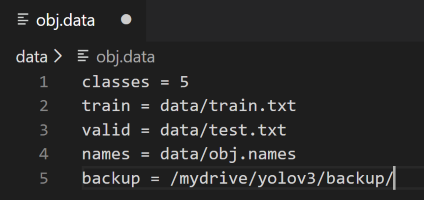



In [14]:
!mkdir ../backup

Inhalt = [
          'classes = 5',
          'train = data/train.txt',
          'names = data/obj.names',
          'backup = ../backup'
]
PathToObjData = 'data/obj.data'

WriteToFile(PathToObjData, Inhalt)


### Zusatz

Extra Weights für das Netz um es einfacher zu machen

In [15]:
# !wget http://pjreddie.com/media/files/darknet53.conv.74

# Training

In [16]:
%cd darknet/

[Errno 20] Not a directory: 'darknet/'
/content/darknet


In [17]:
!./darknet detector train data/obj.data ../drive/My\ Drive/data/yolov3_custom.cfg ../drive/My\ Drive/data/darknet53.conv.74 -dont_show

# Falls es zwischendurch abstürzt:
#!./darknet detector train data/obj.data ../drive/My\ Drive/data/yolov3_custom.cfg ../drive/My\ Drive/backup/yolov3_custom_last.weights -dont_show

Streaming output truncated to the last 5000 lines.
 total_bbox = 237836, rewritten_bbox = 0.006307 % 
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 82 Avg (IOU: 0.000000, GIOU: 0.000000), Class: 0.000000, Obj: 0.000000, No Obj: 0.000075, .5R: 0.000000, .75R: 0.000000, count: 1, class_loss = 0.001344, iou_loss = 0.000000, total_loss = 0.001344 
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 94 Avg (IOU: 0.607989, GIOU: 0.572256), Class: 0.992262, Obj: 0.002741, No Obj: 0.000023, .5R: 0.500000, .75R: 0.500000, count: 2, class_loss = 0.498092, iou_loss = 0.260522, total_loss = 0.758614 
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 106 Avg (IOU: 0.168583, GIOU: 0.155303), Class: 0.995406, Obj: 0.001881, No Obj: 0.000005, .5R: 0.000000, .75R: 0.000000, count: 1, class_loss = 0.249537, iou_loss = 0.229412, total_loss = 0.478949 
 total_bbox = 237839, rewritten_bbox = 0.006307 % 
v3 (mse loss, Normalizer: (iou: 0.75, cls: 1.00) Region 82 Avg (IOU: 0.000000, GIOU:

In [18]:
Ergebnis = Image.open('chart.jpg')
plt.imshow(Ergebnis)

FileNotFoundError: ignored

# Ausgabe des Ergebnis


## Vorbereitung 

In [19]:
!ls

3rdparty	chart_yolov3_custom.png  image_yolov2.sh	publaynet
backup		cmake			 image_yolov3.sh	README.md
bad_label.list	CMakeLists.txt		 include		results
build		darknet			 json_mjpeg_streams.sh	scripts
build.ps1	DarknetConfig.cmake.in	 LICENSE		src
build.sh	darknet.py		 Makefile		video_v2.sh
cfg		darknet_video.py	 net_cam_v3.sh		video_yolov3.sh
chart.png	data			 obj


In [23]:
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov3_custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov3_custom.cfg
%cd ..


/content/darknet/cfg
/content/darknet


## Test

Vorher noch ein Bild hochladen

In [21]:
!curl https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/examples.tar.gz --output "examples.tar.gz"
openTar("examples.tar.gz")
!rm examples.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6309k  100 6309k    0     0  21.1M      0 --:--:-- --:--:-- --:--:-- 21.1M
examples.tar.gz entpacked


 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  wt = 0, wn = 0, outputs: 104 x 104 x

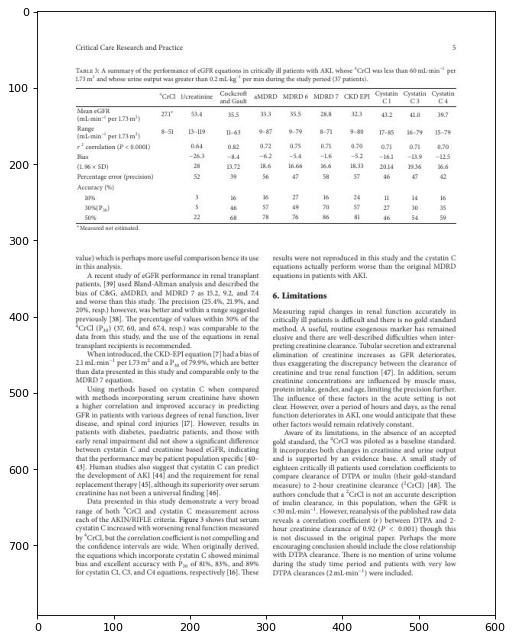

In [27]:
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg ../drive/My\ Drive/backup/yolov3_custom_4000.weights examples/PMC3576793_00004.jpg -thresh 0.3
Ergebnis = Image.open('predictions.jpg')

plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')

plt.imshow(Ergebnis)